グラフ

ノード: 各通貨（USD, EUR, JPY）や経済指標（GDP, インフレ率、失業率）をノードとする。

エッジ: 通貨間（為替レートの相関性や取引量）や通貨と経済指標間の関係性を初期的な隣接行列 𝐴として設定。
- 初期値は事前知識や過去データ（例えば、相関係数）を用いる。
- A は固定せず、GATが学習を通じてエッジ重みを動的に調整。

ノード特徴量

通貨ノード: 現在の価格変動率、移動平均、出来高、ボラティリティなど。

経済指標ノード: 最新のGDP成長率、CPI、金利、貿易収支など。

## Data Preparation

In [1]:
import glob
files = []
symbols = ["EURUSD", "USDJPY", "EURJPY"]

for symbol in symbols:
    files.extend(glob.glob(f'L:/data/fx/HistData/csv/{symbol}*.csv'))

In [2]:
import pandas as pd

df = None

for file in files:
    temp_df = pd.read_csv(file, index_col=0, parse_dates=True, names=["open", "high", "low", "close", "volume"], header=0)
    temp_df = temp_df[~temp_df.index.duplicated(keep='first')]
    resampler = temp_df["close"].resample("1D")
    close_srs = resampler.last()

    if df is None:
        df = close_srs
    else:
        df = pd.concat([df, close_srs], axis=1).dropna()

df.columns = symbols
del temp_df, close_srs, resampler

In [3]:
def approx_min_max(df, max_q, min_q):
    # to reduce an impact of outflier
    apx_max = df.quantile(max_q)
    apx_min = df.quantile(min_q)
    # apply min max
    token_df = (df - apx_min) / (apx_max - apx_min)
    return token_df, apx_max, apx_min

def make_multi_index(df, column, symbols=None):
    if symbols is None:
        symbols = df.columns
    if isinstance(column, str):
        multi_index = pd.MultiIndex.from_product([symbols, [column]], names=["symbol", "attribute"])
    else:
        multi_index = pd.MultiIndex.from_product([symbols, column], names=["symbol", "attribute"])
    df.columns = multi_index
    return df

In [4]:
df.head()

,EURUSD,USDJPY,EURJPY
2002-03-03,0.8656,133.04,115.15
2002-03-04,0.8700,132.37,115.14
2002-03-05,0.8705,132.11,115.02
2002-03-06,0.8780,130.01,114.13
2002-03-10,0.8749,129.14,112.95


### FX

In [5]:
def get_ratio_df(df, symbols, period):
    rev_symbols = [symbol[3:] + symbol[:3] for symbol in symbols]
    ratio_df = df.iloc[period:] / df.iloc[:-period].values
    reverse_ratio_df = (1/df).iloc[period:] / (1/df).iloc[:-period].values
    reverse_ratio_df.columns = rev_symbols
    ratio_df = pd.concat([ratio_df, reverse_ratio_df], axis=1)
    return ratio_df

def get_diff_df(df, symbols, period):
    rev_symbols = [symbol[3:] + symbol[:3] for symbol in symbols]
    diff_df = df.diff(periods=period)
    reverse_diff_df = (1/df).diff(periods=period)
    reverse_diff_df.columns = rev_symbols
    diff_df = pd.concat([diff_df, reverse_diff_df], axis=1).dropna()
    return diff_df

In [6]:
df.head()

,EURUSD,USDJPY,EURJPY
2002-03-03,0.8656,133.04,115.15
2002-03-04,0.8700,132.37,115.14
2002-03-05,0.8705,132.11,115.02
2002-03-06,0.8780,130.01,114.13
2002-03-10,0.8749,129.14,112.95


In [7]:
features = []
periods = [10]
q = [0.999]
token_params = []
symbols = ["EURUSD", "USDJPY", "EURJPY"]
method = "diff"

for index, period in enumerate(periods):
    if method == "ratio":
        token_df = get_ratio_df(df, symbols, period)
    if method == "diff":
        token_df = get_diff_df(df, symbols, period)
    token_df, apx_max, apx_min = approx_min_max(token_df, q[index], 0)
    token_df = make_multi_index(token_df, f"{method}_{period}")
    features.append(token_df)
    token_param = pd.concat([apx_min, apx_max], axis=1, keys=[(f"{method}_{period}", "min"), (f"{method}_{period}", "max")])
    token_params.append(token_param)

symbol_features = pd.concat(features, axis=1).dropna()
token_params = pd.concat(token_params, axis=1)
symbol_features.head()

symbol,EURUSD,USDJPY,EURJPY,USDEUR,JPYUSD,JPYEUR
attribute,diff_10,diff_10,diff_10,diff_10,diff_10,diff_10
2002-03-19,0.605616,0.539393,0.749785,0.485344,0.594752,0.385949
2002-03-20,0.603723,0.533885,0.744077,0.490148,0.598441,0.394751
2002-03-24,0.558302,0.631812,0.747435,0.573145,0.538992,0.389419
2002-03-25,0.527548,0.782986,0.792765,0.630171,0.446096,0.317949
2002-03-26,0.535591,0.814200,0.813918,0.615341,0.425686,0.282070


In [8]:
periods_str = "-".join([str(p) for p in periods])
symbol_features.to_csv(f"./symbol_features_{method}-{periods_str}_token.csv")
token_params.to_csv(f"./symbol_feature_{method}-{periods_str}_token_params.csv")

#### Revert applied transformations

In [129]:
symbol_features = pd.read_csv("symbol_features_token.csv", header=[0, 1], index_col=0)
token_params = pd.read_csv("./symbol_feature_token_params.csv", header=[0, 1], index_col=0)

In [130]:
symbol_features.columns = symbol_features.columns.swaplevel(0, 1)
period = 1

token_df = symbol_features[f"ratio_{period}"]
token_param = token_params[f"ratio_{period}"]

In [ ]:
observation_length = 10
symbol = "USDJPY"

# start index to test
index = 300
apx_min = token_param.loc[symbol, "min"]
apx_max = token_param.loc[symbol, "max"]

output = token_df[symbol].iloc[index+observation_length]
denominator_index = token_df.iloc[index+observation_length-period].name\

reverted_value = (output * (apx_max - apx_min) + apx_min) * df.loc[denominator_index, symbol]

answer_index = token_df.iloc[index+observation_length].name
answer_value = df.loc[answer_index, symbol]

print(reverted_value, answer_value)

### Commodity

In [ ]:
import glob

commodity_symbols = ["oil", "gold"]
commodity_files = []
for symbol in commodity_symbols:
    commodity_files.extend(glob.glob(f'L:/data/stocknet/indicators/*{symbol}*.csv'))
commodity_files

In [ ]:
import pandas as pd

com_df = pd.read_csv(commodity_files[0],index_col=0, parse_dates=True, names=["close", "open", "high", "low", "volume", "pct"], header=0)
com_df.head()

In [806]:
com_df = None

for file in commodity_files:
    temp_df = pd.read_csv(file, index_col=0, parse_dates=True, names=["close", "open", "high", "low", "volume", "pct"], header=0)
    close_srs = temp_df["close"]
    if close_srs.dtype == pd.StringDtype:
        close_srs = close_srs.str.replace(",", "").astype(float)

    if com_df is None:
        com_df = close_srs
    else:
        com_df = pd.concat([com_df, close_srs], axis=1).dropna()

com_df.columns = commodity_symbols
del temp_df, close_srs

In [ ]:
_ = com_df.pct_change().hist(bins=1000)

In [ ]:
EUR_com_df = com_df[commodity_symbols].mul((1/df["EURUSD"]), axis=0)
JPY_com_df = com_df[commodity_symbols].mul((df["USDJPY"]), axis=0)
com_df = pd.concat([com_df, EUR_com_df, JPY_com_df], axis=1).dropna()
com_df = make_multi_index(com_df, commodity_symbols, symbols=["USD", "EUR", "JPY"])
com_df.head()

In [746]:
com_df.to_csv("./commodity_features.csv")

In [ ]:
com_token_df = com_df.pct_change().dropna()
com_token_df.columns = com_token_df.columns.swaplevel(0, 1)
com_stat_df = com_token_df.describe()
com_stat_df

In [ ]:
apprx_min_oil = com_token_df["oil"].quantile(0.01)
apprx_max_oil = com_token_df["oil"].quantile(0.99)

oil_token_df = (com_token_df["oil"] - apprx_min_oil) / (apprx_max_oil - apprx_min_oil)
# there are some outfliers. e.g. 2020/4/20 
oil_token_df.describe()

In [751]:
def mitigate_outflier(df, apx_min_srs, apx_max_srs):
    # instead of ignoring value, mitigate effect of outflier
    DFS = {}
    for symbol in df.columns:
        clipped_symbol_srs = df[symbol].clip(apx_min_srs[symbol], apx_max_srs[symbol])
        outflier_value_srs = (df[symbol] - clipped_symbol_srs).apply(np.tanh)
        symbol_srs = clipped_symbol_srs + outflier_value_srs
        DFS[symbol] = symbol_srs
    return pd.concat(DFS.values(), keys=DFS.keys(), axis=1)

In [ ]:
mitigated_oil_token_df = mitigate_outflier(com_token_df["oil"], apprx_min_oil, apprx_max_oil)
fig, axs = plt.subplots(1,3, figsize=(10, 3))
for i, column in enumerate(mitigated_oil_token_df.columns):
    axs[i].hist(mitigated_oil_token_df[column], bins=1000)
    axs[i].set_xlim(-0.5, 0.5)
fig.show()

In [ ]:
# instead of ignoring value, mitigate effect of outflier
mitigated_oil_token_df = mitigate_outflier(com_token_df["oil"], apprx_min_oil, apprx_max_oil)
apprx_min_oil_mtgt = mitigated_oil_token_df.quantile(0.05)
apprx_max_oil_mtgt = mitigated_oil_token_df.quantile(0.995)

mitigated_oil_token_df = (mitigated_oil_token_df - apprx_min_oil_mtgt) / (apprx_max_oil_mtgt - apprx_min_oil_mtgt)
mitigated_oil_token_df.describe()

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,3, figsize=(10, 3))
for i, column in enumerate(mitigated_oil_token_df.columns):
    axs[i].hist(mitigated_oil_token_df[column], bins=1000)
    axs[i].set_xlim(-1, 1)
fig.show()

In [ ]:
max_gold = com_stat_df["gold"].loc["max"]
apprx_max_gold = com_token_df["gold"].quantile(0.99)
apprx_min_gold = com_token_df["gold"].quantile(0.01)

gold_token_df = (com_token_df["gold"] - apprx_min_gold) / (apprx_max_gold - apprx_min_gold)
gold_token_df.describe()

In [ ]:
_ = gold_token_df.hist(bins=1000)

In [ ]:
com_token_df = pd.concat([oil_token_df, gold_token_df], axis=1)
multi_index = pd.MultiIndex.from_product(
    [commodity_symbols, ["USD", "EUR", "JPY"]],
    names=["attribute", "symbol"])
com_token_df.columns = multi_index.swaplevel(0, 1)
com_token_df = com_token_df[["USD", "EUR", "JPY"]]
com_token_df.head()

In [144]:
com_token_df.to_csv("./commodity_features_token.csv")

In [ ]:
com_token_df = pd.concat([mitigated_oil_token_df, gold_token_df], axis=1)
multi_index = pd.MultiIndex.from_product(
    [commodity_symbols, ["USD", "EUR", "JPY"]],
    names=["attribute", "symbol"])
com_token_df.columns = multi_index.swaplevel(0, 1)
com_token_df = com_token_df[["USD", "EUR", "JPY"]]
com_token_df.head()

In [833]:
com_token_df.to_csv("./commodity_features_mitigated_token.csv")

### Bond and Stock

In [ ]:
additional_feature_symbol_dict = {
    "USD": ["US-10-year-bond-yield", "NY_daw"],
    "EUR": ["germany-10-year-bond",  "dax_price"],
    "JPY": ["japan-10-year-bond", "japan-ni225"]
}
additional_feature_symbols = ["bond", "stock"]
additional_feature_files = []

for symbol_key_list in additional_feature_symbol_dict.values():
    for symbol_key in symbol_key_list:
         additional_feature_files.extend(glob.glob(f'L:/data/stocknet/indicators/*{symbol_key}*.csv'))
additional_feature_files

In [146]:
import pandas as pd

feature_df = None

for file in additional_feature_files:
    temp_df = pd.read_csv(file, index_col=0, parse_dates=True, header=0)
    if len(temp_df.columns) == 5:
        temp_df.columns = ["close", "open", "high", "low", "pct"]
    else:
        temp_df.columns = ["close", "open", "high", "low", "volume", "pct"]
    temp_df = temp_df[~temp_df.index.duplicated(keep='first')]
    close_srs = temp_df["close"]
    if close_srs.dtype == pd.StringDtype:
        close_srs = close_srs.str.replace(",", "").astype(float)

    if feature_df is None:
        feature_df = close_srs
    else:
        feature_df = pd.concat([feature_df, close_srs], axis=1).dropna()

multi_index = pd.MultiIndex.from_product(
    [["USD", "EUR", "JPY"], additional_feature_symbols],
    names=["symbol", "attribute"])
feature_df.columns = multi_index
feature_df.index.name = "date"
del temp_df, close_srs

In [ ]:
feature_df.head()

In [ ]:
pct_df = feature_df.pct_change().dropna()
pct_df.plot()

In [ ]:
feature_df[feature_df == 0].dropna(how="all")
feature_df.columns = feature_df.columns.swaplevel(0,1)
stock_token_df = feature_df["stock"].pct_change().dropna()
stock_token_df.head()

In [ ]:
stock_token_stat = stock_token_df.describe()
stock_token_stat

In [ ]:
apprx_min_stock = stock_token_df.quantile(0.001)
min_stock = stock_token_stat.loc["min"]
apprx_max_stock = stock_token_df.quantile(0.995)
max_stock = stock_token_stat.loc["max"]

stock_token_std_df = (stock_token_df - apprx_min_stock) / (apprx_max_stock - apprx_min_stock)
stock_token_std_df.head()

In [ ]:
_ = stock_token_std_df.hist(bins=1000)

In [153]:
stock_token_std_df.to_csv("stock_pct_token.csv")

In [154]:
bond_diff_uj = feature_df["bond"]["USD"] - feature_df["bond"]["JPY"]
bond_diff_ue = feature_df["bond"]["USD"] - feature_df["bond"]["EUR"]
bond_diff_ej = feature_df["bond"]["EUR"] - feature_df["bond"]["JPY"]

In [ ]:
bond_symbol_diff_df = pd.concat([bond_diff_uj, bond_diff_ue, bond_diff_ej], keys=["UJ", "UE", "EJ"], axis=1)
bond_symbol_diff_df.plot()

In [ ]:
bond_symbol_diff_token_df = ((bond_symbol_diff_df +1)/6)
_ = bond_symbol_diff_token_df.hist(bins=1000)

In [157]:
bond_symbol_diff_token_df.to_csv("./bond_symbol_diff_token.csv")

In [ ]:
bond_diff_df = feature_df["bond"].diff().dropna()
bond_diff_df.plot()

In [ ]:
bond_diff_stat = bond_diff_df.describe()
bond_diff_stat

In [ ]:
apprx_min_bond = bond_diff_df.quantile(0.001)
min_bond = bond_diff_stat.loc["min"]
apprx_max_bond = bond_diff_df.quantile(0.995)
max_bond = bond_diff_stat.loc["max"]

bond_token_std_df = (bond_diff_df - apprx_min_bond) / (apprx_max_bond - apprx_min_bond)
bond_token_std_df.head()

In [ ]:
_ = bond_token_std_df.hist(bins=1000)

In [162]:
bond_token_std_df.to_csv("./bond_diff_token.csv")

## Feature Vector

In [9]:
import re

def load_token_df(token_files, symbols = ["USD", "EUR", "JPY"]):
    token_columns = {}
    feature_df = None

    for symbol in symbols:
        pattern = rf"{symbol}.*"
        token_columns[symbol] = {}
        for key, __df in tokens.items():
            symbol_columns = []
            for columns in __df.columns:
                if isinstance(columns, tuple):
                    # columns = (symbol, attribute)
                    match = re.match(pattern, columns[0])
                else:
                    # columns = symbol
                    match = re.match(pattern, columns)
                if match:
                    symbol_columns.append(columns)

            token_columns[symbol][key] = symbol_columns
    
    for symbol in symbols:
        symbol_feature_df = None
        for key, columns in token_columns[symbol].items():
            __df = tokens[key][columns]
            if len(columns) == 1 and columns[0] == symbol:
                __df.columns = [key]
            else:
                columns = ["_".join(column) for column in columns]
                __df.columns = columns
            if symbol_feature_df is None:
                symbol_feature_df = __df
            else:
                symbol_feature_df = pd.concat([symbol_feature_df, __df], axis=1).dropna()
        multi_index = pd.MultiIndex.from_product([[symbol], symbol_feature_df.columns], names=["symbol", "attribute"])
        symbol_feature_df.columns = multi_index
        if feature_df is None:
            feature_df = symbol_feature_df
        else:
            feature_df = pd.concat([feature_df, symbol_feature_df], axis=1)
    return feature_df

In [ ]:
import pandas as pd

symbol_df = pd.read_csv("symbol_features_token.csv", header=[0, 1], index_col=0)
# com_df = pd.read_csv("commodity_features_token.csv", header=[0, 1], index_col=0)
# bond_df = pd.read_csv("bond_diff_token.csv", header=0, index_col=0)
# bond_sdiff_df = pd.read_csv("bond_symbol_diff_token.csv", header=0, index_col=0)
# stock_df = pd.read_csv("stock_pct_token.csv", header=0, index_col=0)

tokens = {
    "currency": symbol_df,
    # "commodity": com_df,
    # "bond": bond_df,
    # "stock": stock_df
}

feature_df = load_token_df(tokens)
feature_df.head()

## Model Definition and Test it

For each observation X_t, calculate attention weight. Use it as adjacency matrix.
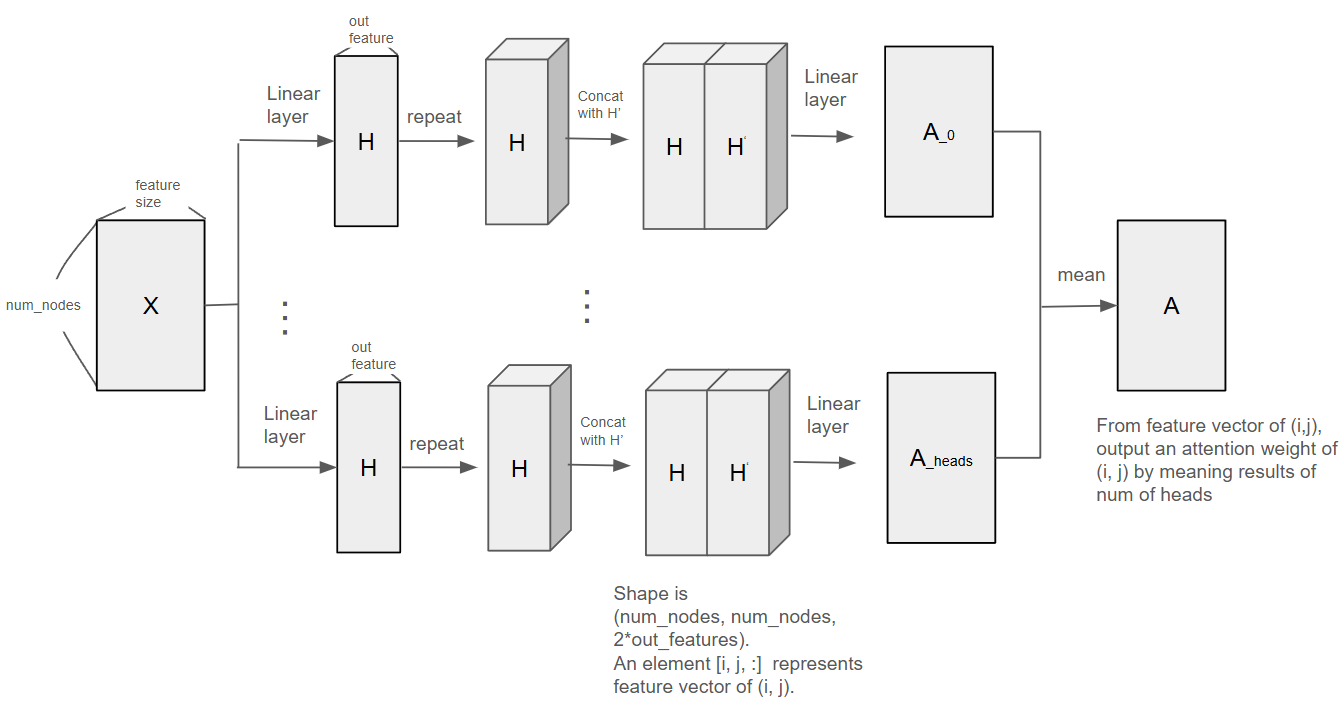

In [47]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TimeSeriesGAT(nn.Module):
    def __init__(self, in_features, out_features, num_heads):
        super(TimeSeriesGAT, self).__init__()
        self.gat_layers = nn.ModuleList([
            nn.Linear(in_features, out_features) for _ in range(num_heads)
        ])
        self.attention_layers = nn.ModuleList([
            nn.Linear(2 * out_features, 1) for _ in range(num_heads)
        ])
        self.num_heads = num_heads

    def forward(self, X):
        # X shape: (num_nodes, length, in_features)
        num_nodes, length, in_features = X.shape
        adjacency_matrices = []  # To store A_t for each timestep
        
        for t in range(length):  # Process each time slice
            X_t = X[:, t, :]  # Shape: (num_nodes, in_features)
            head_adjacencies = []

            for head in range(self.num_heads):
                H = self.gat_layers[head](X_t)  # Shape: (num_nodes, out_features)
                H_repeat = H.unsqueeze(0).repeat(num_nodes, 1, 1)  # Shape: (num_nodes, num_nodes, out_features)
                H_concat = torch.cat([H_repeat, H_repeat.transpose(0, 1)], dim=-1)  # Shape: (num_nodes, num_nodes, 2*out_features)
                attention = F.leaky_relu(self.attention_layers[head](H_concat))  # Shape: (num_nodes, num_nodes, 1)
                attention = F.softmax(attention, dim=1).squeeze(-1)  # Shape: (num_nodes, num_nodes)
                head_adjacencies.append(attention)

            # Combine attention heads into a single adjacency matrix
            A_t = torch.mean(torch.stack(head_adjacencies, dim=0), dim=0)  # Shape: (num_nodes, num_nodes)
            adjacency_matrices.append(A_t)

        return torch.stack(adjacency_matrices, dim=0)  # Shape: (length, num_nodes, num_nodes)

In [48]:
class TimeSeriesGNN(nn.Module):
    def __init__(self, in_features, embedding_dim):
        super(TimeSeriesGNN, self).__init__()
        self.linear = nn.Linear(in_features, embedding_dim)

    def forward(self, A, X):
        # A shape: (length, num_nodes, num_nodes)
        # X shape: (length, num_nodes, in_features)
        length, num_nodes, _ = A.shape
        embeddings = []

        for t in range(length):
            A_t = A[t]  # Shape: (num_nodes, num_nodes)
            X_t = X[t]  # Shape: (num_nodes, in_features)
            H_t = F.relu(A_t @ self.linear(X_t))  # Shape: (num_nodes, embedding_dim)
            embeddings.append(H_t)

        return torch.stack(embeddings, dim=0)  # Shape: (length, num_nodes, embedding_dim)


In [49]:
class TimeSeriesPredictor(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim):
        super(TimeSeriesPredictor, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, H):
        # H shape: (length, num_nodes, embedding_dim)
        length, num_nodes, embedding_dim = H.shape
        H_flat = H.permute(1, 0, 2)  # Shape: (num_nodes, length, embedding_dim)
        lstm_out, _ = self.lstm(H_flat)  # Shape: (num_nodes, length, hidden_dim)
        predictions = self.fc(lstm_out)  # Shape: (num_nodes, length, output_dim)
        return predictions.permute(1, 0, 2)  # Shape: (length, num_nodes, output_dim)

In [50]:
class TimeGraphModel(nn.Module):
    def __init__(self, in_features, out_features, num_heads, embedding_dim, hidden_dim, output_dim):
        super(TimeGraphModel, self).__init__()
        self.gat = TimeSeriesGAT(in_features, out_features, num_heads)
        self.gnn = TimeSeriesGNN(in_features, embedding_dim)
        self.predictor = TimeSeriesPredictor(embedding_dim, hidden_dim, output_dim)

    def forward(self, X):
        # X shape: (num_nodes, length, in_features)
        A = self.gat(X)  # Shape: (length, num_nodes, num_nodes)
        H = self.gnn(A, X.permute(1, 0, 2))  # Shape: (length, num_nodes, embedding_dim)
        predictions = self.predictor(H)  # Shape: (length, num_nodes, output_dim)   
        return predictions

In [220]:
# sample observation to test model
feature_x = feature_df.iloc[0:10]
X_t = [feature_x[symbol].values.tolist() for symbol in symbols]
X_t = torch.tensor(X_t)

num_nodes, _, feature_dim = X_t.shape

model = TimeGraphModel(in_features=feature_dim, out_features=2, embedding_dim=4, num_heads=4, hidden_dim=5, output_dim=1)
y = model(X_t)
y.shape

In [41]:
import random
from collections.abc import Iterable

import numpy as np
import torch
from torch.utils.data import Dataset

class FeatureDataset(Dataset):

    def __init__(
        self,
        df,
        symbols: list,
        observation_length,
        device="cuda",
        seed=1017,
        is_training=True,
        randomize=True,
        split_ratio=0.9,
        dtype=torch.float,
        batch_size = None
    ):
        self.seed(seed)
        self.data = df
        self.dtype = dtype
        self.is_training = is_training
        self.device = device
        self._columns = symbols
        self.observation_length = observation_length
        self._split_ratio = split_ratio
        self.batch_size = batch_size
        self._init_indicies(randomize)

    def _init_indicies(self, randomize=True):
        train_data_length = int(len(self.data.index) * self._split_ratio)
        train_indices = list(range(self.observation_length, train_data_length))
        eval_indices = list(range(train_data_length + self.observation_length, len(self.data.index)))
        if randomize:
            train_indices = random.sample(train_indices, k=len(train_indices))
            eval_indices = random.sample(eval_indices, k=len(eval_indices))
        self.train_indices, self.eval_indices = train_indices, eval_indices

        if self.is_training:
            self._indices = self.train_indices
        else:
            self._indices = self.eval_indices
    
    def output_indices(self, index):
        # return slice(index - self.observation_length + 1, index + 1)
        return index

    def _output_func(self, batch_size):
        indices = self._indices[batch_size]
        if type(indices) == int:
            ndx = self.output_indices(indices)
            feature_y = self.data.iloc[ndx]
            y = [feature_y[symbol].values.tolist() for symbol in self._columns]
            ans = torch.tensor(y, device=self.device, dtype=self.dtype)
            return ans
        else:
            chunk_data = []
            for index in indices:
                ndx = self.output_indices(index)
                feature_y = self.data.iloc[ndx]
                y = [feature_y[symbol].values.tolist() for symbol in self._columns]
                chunk_data.append(y)
            ans = torch.tensor(chunk_data, device=self.device, dtype=self.dtype)
            return ans

    def input_indices(self, index):
        return slice(index - self.observation_length, index)

    def _input_func(self, batch_size):
        indices = self._indices[batch_size]
        if type(indices) == int:
            ndx = self.input_indices(indices)
            feature_x = self.data.iloc[ndx]
            x = [feature_x[symbol].values.tolist() for symbol in self._columns]
            src = torch.tensor(x, device=self.device, dtype=self.dtype)
            return src
        else:
            chunk_src = []
            for index in indices:
                ndx = self.input_indices(index)
                feature_x = self.data.iloc[ndx]
                x = [feature_x[symbol].values.tolist() for symbol in self._columns]
                chunk_src.append(x)

            src = torch.tensor(chunk_src, device=self.device, dtype=self.dtype)
            return src

    def __len__(self):
        return len(self._indices)

    def __getitem__(self, ndx):
        return self._input_func(ndx), self._output_func(ndx)
    
    def __iter__(self):
        self._init_indicies()
        self._index = self.observation_length
        if self.batch_size is None or self.batch_size == 1:
            self.batch_size = 1
            self._get_itr_ndx = lambda i: i
        else:
            self._get_itr_ndx = lambda i: slice(i, i + self.batch_size)
        return self
 
    def __next__(self):
        if self._index + self.batch_size >= len(self):
            raise StopIteration
        ndx = self._get_itr_ndx(self._index)
        self._index += self.batch_size
        return self._input_func(ndx), self._output_func(ndx)

    def seed(self, seed=None):
        """ """
        if seed is None:
            seed = 1017
        else:
            torch.backends.cudnn.benchmark = False
            torch.backends.cudnn.deterministic = True
        torch.manual_seed(seed)
        random.seed(seed)
        np.random.seed(seed)
        self.seed_value = seed

    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)

    def render(self, mode="human", close=False):
        """ """
        pass

    def eval(self):
        self._indices = random.sample(self.eval_indices, k=len(self.eval_indices))
        self.is_training = False

    def train(self):
        self._indices = random.sample(self.train_indices, k=len(self.train_indices))
        self.is_training = True

    def get_index_range(self):
        return min(self._indices), max(self._indices)

    def get_date_range(self):
        min_index, max_index = self.get_index_range()
        return self.data.index[min_index], self.data.index[max_index]

    def get_actual_index(self, ndx):
        inputs = []
        if type(ndx) == slice:
            inputs = self._indices[ndx]
        elif isinstance(ndx, Iterable):
            for index in ndx:
                inputs.append(self._indices[index])
        else:
            return self._indices[ndx]

        return inputs

    def get_row_data(self, ndx):
        inputs = []
        if type(ndx) == slice:
            for index in self._indices[ndx]:
                df = self.data.iloc[index - self.observation_length : index]
                inputs.append(df)
        else:
            index = ndx
            inputs = df = self.data.iloc[index -self.observation_length: index]
        return inputs

In [ ]:
ds = FeatureDataset(feature_df, symbols=["USD", "EUR", "JPY"], observation_length=10, device="cpu")

## Training

In [45]:
import csv
import warnings

def save_checkpoint(model, optimizer, scheduler, model_name, model_version, data_folder="./"):
    if model is not None:
        model_path = os.path.join(data_folder, f'{model_name}_v{model_version}.torch')
        torch.save({
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        }, model_path)

def save_logs(log_file_path, log_array):
    try:
        with open(log_file_path, 'a', newline="") as log_file:
            writer = csv.writer(log_file)
            writer.writerow(log_array)
    except Exception as e:
        warnings.warn(f"failed to save logs due to {e}")

def load_model(model_name, model_version, device, train=True, model_folder=None, model_class=None, optimizer_class=None, scheduler_class=None):
  if model_folder is None:
    model_folder = "."

  params_file_name = f'{model_folder}/{model_name}_params_v{model_version}.json'
  if os.path.exists(params_file_name) is False:
    print(f"exsisting model params not found on {params_file_name}.")
    return None, None, None, None
  with open(params_file_name) as fp:
      params = json.load(fp)
  # need to create create_model function for respective model
  model = model_class(**params).to(device)
  optimizer = optimizer_class(model.parameters(), lr=0.001)
  scheduler = scheduler_class(optimizer, 1.0)
  if train:
    model_path = f'{model_folder}/{model_name}_train_v{model_version}.torch'
  else:
    model_path = f'{model_folder}/{model_name}_v{model_version}.torch'
  if os.path.exists(model_path) is False:
    print(f"exsisting model not found at {model_path}.")
    return None, None, None, None

  if torch.cuda.is_available():
    check_point = torch.load(model_path)
  else:
    check_point = torch.load(model_path, map_location=torch.device('cpu'), weights_only=True)
  if "model_state_dict" in check_point:
    model.load_state_dict(check_point['model_state_dict'])
    optimizer.load_state_dict(check_point['optimizer_state_dict'])
    scheduler.load_state_dict(check_point['scheduler_state_dict'])
    return params, model, optimizer, scheduler
  else:
    if optimizer_class is not None:
      print("checkpoint is not available.")
    model.load_state_dict(check_point)
    return params, model, None, None

In [ ]:
import json
import os

feature_x = feature_df.iloc[0:10]
X_t = [feature_x[symbols[0]].values.tolist() for symbol in symbols]
X_t = torch.tensor(X_t)
num_nodes, _, feature_dim = X_t.shape

model_name = "gnn_cm_mtgt"
model_version = 1
criterion = nn.MSELoss()

params = {
    # feature vector size of a node
    "in_features": feature_dim,
    # num heads to meaning adjacency matrix
    "num_heads": 4,
    # hidden feature vector to calculate adjacency matrices
    "out_features": 2, 
    "embedding_dim": 4,
    # hidden dim of LSTM of predictor
    "hidden_dim": 5,
    "output_dim": feature_dim
}
params_num = 0
param_file_name = f'{model_name}_params_v{model_version}.json'

if os.path.exists(param_file_name):
    print("file already exists")
    try:
        loaded_params, model, optimizer, scheduler = load_model(model_name, model_version, "cpu", train=False,
        model_class=TimeGraphModel, optimizer_class=torch.optim.Adam, scheduler_class=torch.optim.lr_scheduler.StepLR)
    except Exception as e:
        print(e)
else:
    with open(param_file_name, "w") as fp:
        json.dump(params, fp)
    model = TimeGraphModel(**params)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.9)
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
    if p.requires_grad:
        params_num += p.numel()
print(f"params: {params_num}")

In [ ]:
import math
import time

epochs = 500
best_train_loss = np.inf
best_valid_loss = np.inf
best_model = None
best_train_model = None
patience = 3
counter = 0


for epoch in range(epochs):
    model = model.train()
    ds.train()
    loss_train = 0

    start_time = time.time()

    for X, Y in ds:
        outputs = model(X)  # Shape: (length, num_nodes, out_features)
        loss = criterion(outputs[-1], Y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_train += loss.item()
    elapsed_time = time.time() - start_time

    loss_train = loss_train / len(ds)
    
    model = model.eval()
    ds.eval()
    loss_valid = 0
    for X, Y in ds:
        outputs = model(X)  # Shape: (length, num_nodes, out_features)
        loss = criterion(outputs[-1], Y)
        loss_valid += loss.item()
    
    loss_valid = loss_valid / len(ds)

    if best_train_loss > loss_train:
        best_train_loss = loss_train
        best_train_model = model
        counter = 0
    else:
        counter += 1
        if counter == 1:
            save_checkpoint(best_train_model, optimizer, scheduler, f'{model_name}_train', model_version)
        scheduler.step()
    
    if best_valid_loss > loss_valid:
        best_valid_loss = loss_valid
        best_model = model
        save_checkpoint(best_model, optimizer, scheduler, model_name, model_version)

    if counter > patience:
        break


    elasped_display = str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else ''
    print(f'[{epoch+1}/{epochs}] train loss: {loss_train:.10f}, valid loss: {loss_valid:.10f} {elasped_display}{elapsed_time % 60:.0f}s count: {counter} {"**" if best_valid_loss > loss_valid else ""}')
    save_logs(f'{model_name}_v{model_version}.log', [time.time(), epoch, loss_train, loss_valid, elapsed_time])

### Training Loop

In [512]:
feature_x = feature_df.iloc[0:10]
X_t = [feature_x[symbols[0]].values.tolist() for symbol in symbols]
X_t = torch.tensor(X_t)
num_nodes, _, feature_dim = X_t.shape

model_versions = [1, 2, 3, 4]
out_features = [feature_dim, feature_dim*2, feature_dim*4, feature_dim*8]
embedding_dims = [int(feature_dim/2), feature_dim, feature_dim*2, feature_dim*4]
hidden_dims = [5, 10, 20, 40]

In [ ]:
import json
import os
import math
import time

from IPython.display import clear_output

model_name = "gnn_df10"
epochs = 1000

for index, model_version in enumerate(model_versions):
    clear_output(wait=True)
    params = {
        # feature vector size of a node
        "in_features": feature_dim,
        # num heads to meaning adjacency matrix
        "num_heads": 4,
        # hidden feature vector to calculate adjacency matrices
        "out_features": out_features[index], 
        "embedding_dim": embedding_dims[index],
        # hidden dim of LSTM of predictor
        "hidden_dim": hidden_dims[index],
        "output_dim": feature_dim
    }

    params_num = 0
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
        if p.requires_grad:
            params_num += p.numel()
    print(f"params: {params_num}")

    param_file_name = f'{model_name}_params_v{model_version}.json'

    if os.path.exists(param_file_name):
        print(f"file already exists: {param_file_name}") 
        continue
    else:
        with open(param_file_name, "w") as fp:
            json.dump(params, fp)
    
    model = TimeGraphModel(**params)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma = 0.9)

    # initialize training vars
    best_train_loss = np.inf
    best_valid_loss = np.inf
    best_model = None
    best_train_model = None
    patience = 3
    counter = 0

    for epoch in range(epochs):
        model = model.train()
        ds.train()
        loss_train = 0

        start_time = time.time()

        for X, Y in ds:
            outputs = model(X)  # Shape: (length, num_nodes, out_features)
            loss = criterion(outputs[-1], Y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            loss_train += loss.item()
        elapsed_time = time.time() - start_time

        loss_train = loss_train / len(ds)
        
        model = model.eval()
        ds.eval()
        loss_valid = 0
        for X, Y in ds:
            outputs = model(X)  # Shape: (length, num_nodes, out_features)
            loss = criterion(outputs[-1], Y)
            loss_valid += loss.item()
        
        loss_valid = loss_valid / len(ds)

        if best_train_loss > loss_train:
            best_train_loss = loss_train
            best_train_model = model
            counter = 0
        else:
            counter += 1
            if counter == 1:
                save_checkpoint(best_train_model, optimizer, scheduler, f'{model_name}_train', model_version)
            scheduler.step()
        
        if best_valid_loss > loss_valid:
            best_valid_loss = loss_valid
            best_model = model
            save_checkpoint(best_model, optimizer, scheduler, model_name, model_version)

        if counter > patience:
            break


        elasped_display = str(int(math.floor(elapsed_time / 60))) + 'm' if math.floor(elapsed_time / 60) > 0 else ''
        print(f'[{epoch+1}/{epochs}] train loss: {loss_train:.10f}, valid loss: {loss_valid:.10f} {elasped_display}{elapsed_time % 60:.0f}s count: {counter} {"**" if best_valid_loss > loss_valid else ""}')
        save_logs(f'{model_name}_v{model_version}.log', [time.time(), epoch, loss_train, loss_valid, elapsed_time])

## Evaluation

In [42]:
import pandas as pd

symbol_df = pd.read_csv("L:/data/stocknet/logs/gnn/symbol_features_p10_token.csv", header=[0, 1], index_col=0)
# com_df = pd.read_csv("commodity_features_token.csv", header=[0, 1], index_col=0)
# bond_df = pd.read_csv("bond_diff_token.csv", header=0, index_col=0)
# bond_sdiff_df = pd.read_csv("bond_symbol_diff_token.csv", header=0, index_col=0)
# stock_df = pd.read_csv("stock_pct_token.csv", header=0, index_col=0)

tokens = {
    "currency": symbol_df,
    # "commodity": com_df,
    # "bond": bond_df,
    # "stock": stock_df
}

feature_df = load_token_df(tokens)
ds = FeatureDataset(feature_df, symbols=["USD", "EUR", "JPY"], observation_length=10, device="cpu")

In [43]:
model_name = "gnn_p10"
model_version = 1

In [54]:
import os, json

params, model, optimizer, scheduler = load_model(
    model_name=model_name,
    model_version=model_version,
    device="cpu",
    train=False,
    model_folder="L:/data/stocknet/logs/gnn",
    model_class=TimeGraphModel,
    optimizer_class=torch.optim.Adam,
    scheduler_class=torch.optim.lr_scheduler.StepLR
)

In [55]:
params_num = 0
for p in model.parameters():
    if p.requires_grad:
        params_num += p.numel()
print(f"params: {params_num}")

params: 219


In [56]:
ds.eval()
model = model.eval()

In [880]:
answers = None
predictions = None

for X, Y in ds:
    outputs = model(X)  # Shape: (length, num_nodes, out_features)

    ans = Y.cpu().detach().numpy()
    pre = outputs[-1].cpu().detach().numpy()
    ans = ans.reshape(1, *ans.shape)
    pre = pre.reshape(1, *pre.shape)

    if answers is None:
        answers = ans
        predictions = pre
    else:
        answers = np.append(answers, ans, axis=0)
        predictions = np.append(predictions, pre, axis=0)

In [ ]:
import matplotlib.pyplot as plt

# (length, num_nodes, num_features)
_, num_symbols, num_features = answers.shape

fig, axs = plt.subplots(num_symbols, num_features, figsize=(4*num_features, num_features*num_symbols))

for symbol_index in range(num_symbols):
    symbol_str = symbols[symbol_index]
    f_columns = feature_df[symbol_str].columns

    for f_index in range(num_features):
        axs[symbol_index, f_index].scatter(answers[:, symbol_index, f_index], predictions[:, symbol_index, f_index], alpha=0.3)
        axs[symbol_index, f_index].set_title(f"{symbol_str}:{f_columns[f_index]}")
fig.show()

In [ ]:
symbols = ["USD", "EUR", "JPY"]

for i, symbol in enumerate(symbols):
    print(f"{symbol}:", np.mean((answers[:, i] - predictions[:, i]) ** 2, axis=0))

Plot losses from training log

In [11]:
import matplotlib
import matplotlib.pyplot as plt

periods = ["10", "20"]

log_files = [f"L:/data/stocknet/logs/gnn/gnn_p{period}_v4.log" for period in periods]
losses = []

for file in log_files:
    log_df = pd.read_csv(file, header=None, names=["time", "count", "train_loss", "eval_loss", "elapsed"])
    losses.append(log_df)

C:\Users\ksato\AppData\Local\Temp\ipykernel_35944\3177015143.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


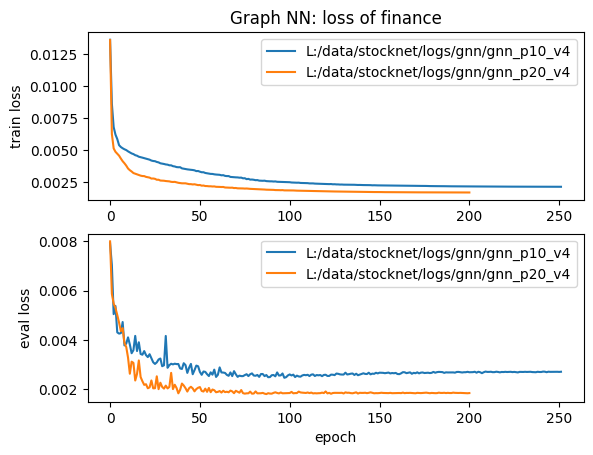

In [12]:
import matplotlib
fig, axs = plt.subplots(2)

for index, log in enumerate(losses):
    file = log_files[index]
    model_name = file.split(".")[0]
    axs[0].plot(log["train_loss"], label=model_name)
    axs[1].plot(log["eval_loss"], label=model_name)

axs[0].set_title("Graph NN: loss of finance")
axs[0].legend()
axs[1].legend()
axs[1].set_xlabel("epoch")
axs[0].set_ylabel("train loss")
axs[1].set_ylabel("eval loss")
fig.show()

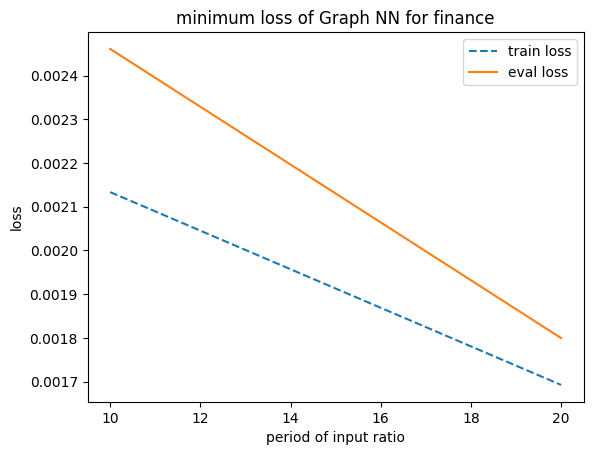

In [14]:
train_min_loss = []
eval_min_loss = []
_periods = [int(period) for period in periods]

for index, log in enumerate(losses):
    train_min_loss.append(log["train_loss"].min())
    eval_min_loss.append(log["eval_loss"].min())

plt.plot(_periods, train_min_loss, linestyle="--", label="train loss")
plt.plot(_periods, eval_min_loss, label="eval loss")

plt.title("minimum loss of Graph NN for finance")
plt.ylabel("loss")
plt.xlabel("period of input ratio")
plt.legend()
plt.show()

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

versions = ["1", "2", "3", "4"]

log_files = [f"L:/data/stocknet/logs/gnn/gnn_p20_v{version}.log" for version in versions]
losses = []

for file in log_files:
    log_df = pd.read_csv(file, header=None, names=["time", "count", "train_loss", "eval_loss", "elapsed"])
    losses.append(log_df)

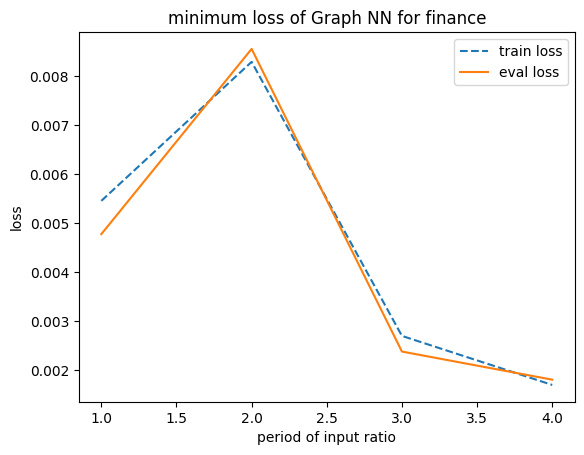

In [17]:
train_min_loss = []
eval_min_loss = []
_versions = [int(version) for version in versions]

for index, log in enumerate(losses):
    train_min_loss.append(log["train_loss"].min())
    eval_min_loss.append(log["eval_loss"].min())

plt.plot(_versions, train_min_loss, linestyle="--", label="train loss")
plt.plot(_versions, eval_min_loss, label="eval loss")

plt.title("minimum loss of Graph NN for finance")
plt.ylabel("loss")
plt.xlabel("period of input ratio")
plt.legend()
plt.show()

Revert token to prices

In [75]:
token_param_file = "L:/data/stocknet/logs/gnn/symbol_feature_p10_token_params.csv"
token_params = pd.read_csv(token_param_file, header=[0, 1], index_col=0)
symbols = ["USD", "EUR", "JPY"]
original_symbols = ["EURUSD", "USDJPY", "EURJPY"]
method = "ratio_10"
token_param = token_params[method]
# token_df = feature_df.xs(f"{symbol}_{method}", axis=1, level=1)

symbol_params = []
for p_index, symbol in enumerate(symbols):
    f_index = 0
    for c_symbol in symbols:
        if symbol != c_symbol:
            feature_symbol = f"{symbol}{c_symbol}"
            symbol_params.append({ "node_index": p_index, "feature_index": f_index, "symbol": feature_symbol, 
            "min": token_param.loc[feature_symbol, "min"], "max": token_param.loc[feature_symbol, "max"], "reversed": feature_symbol not in original_symbols})
            f_index += 1

answers = None
answers_pct = None
answers_org = None

predictions = None
predictions_pct = None
predictions_rvt = None

for X, Y in ds:
    index = ds._get_itr_ndx(ds._index) - 1 # batch size was added after interation
    y_ndx = ds.output_indices(index)
    y_ndx = ds.get_actual_index(y_ndx)

    outputs = model(X)

    ans = Y.cpu().detach().numpy()
    pre = outputs[-1].cpu().detach().numpy()
    
    token_srs = feature_df.iloc[y_ndx]
    answer_index = token_srs.name
    denominator_index = feature_df.iloc[y_ndx-period].name

    answers_pct_ele = []
    answers_org_ele = []
    
    predictions_pct_ele = []
    predictions_rvt_ele = []

    for symbol_param in symbol_params:
        symbol = symbol_param["symbol"]
        node_index = symbol_param["node_index"]
        node_symbol = symbols[node_index]
        f_index = symbol_param["feature_index"]
        apx_max = symbol_param["max"]
        apx_min = symbol_param["min"]
        is_reversed = symbol_param["reversed"]

        output = pre[node_index, f_index]
        pct_value = (output * (apx_max - apx_min) + apx_min)
        ans_pct_value = token_srs[node_symbol][f"{symbol}_{method}"] * (apx_max - apx_min) + apx_min
        if is_reversed:
            rev_symbol = f"{symbol[3:]}{symbol[:3]}"
            denominator_value = 1/df.loc[denominator_index, rev_symbol]
            answer_value = 1/df.loc[answer_index, rev_symbol]
        else:
            denominator_value = df.loc[denominator_index, symbol]
            answer_value = df.loc[answer_index, symbol]
        reverted_value = pct_value * denominator_value

        answers_pct_ele.append(ans_pct_value)
        answers_org_ele.append(answer_value)

        predictions_pct_ele.append(pct_value)
        predictions_rvt_ele.append(reverted_value)
    
    answers_pct_ele = np.asarray(answers_pct_ele)[np.newaxis, :]
    answers_org_ele = np.asarray(answers_org_ele)[np.newaxis, :]
    predictions_pct_ele = np.asarray(predictions_pct_ele)[np.newaxis, :]
    predictions_rvt_ele = np.asarray(predictions_rvt_ele)[np.newaxis, :]

    if answers is None:
        answers = ans
        answers_pct = answers_pct_ele
        answers_org = answers_org_ele

        predictions = pre
        predictions_pct = predictions_pct_ele
        predictions_rvt = predictions_rvt_ele
    else:
        answers = np.append(answers, ans, axis=0)
        answers_pct = np.append(answers_pct, answers_pct_ele, axis=0)
        answers_org = np.append(answers_org, answers_org_ele, axis=0)

        predictions = np.append(predictions, pre, axis=0)
        predictions_pct = np.append(predictions_pct, predictions_pct_ele, axis=0)
        predictions_rvt = np.append(predictions_rvt, predictions_rvt_ele, axis=0)

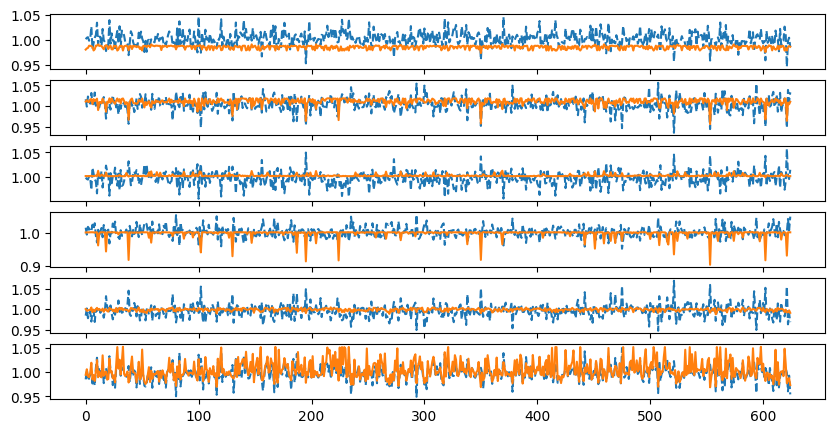

In [85]:
_, feature_num = predictions_pct.shape

fig, axs = plt.subplots(feature_num, figsize=(10, 5))

for f_index in range(feature_num):
    axs[f_index].plot(answers_pct[:, f_index], linestyle="--")
    axs[f_index].plot(predictions_pct[:, f_index])
# fig.show()

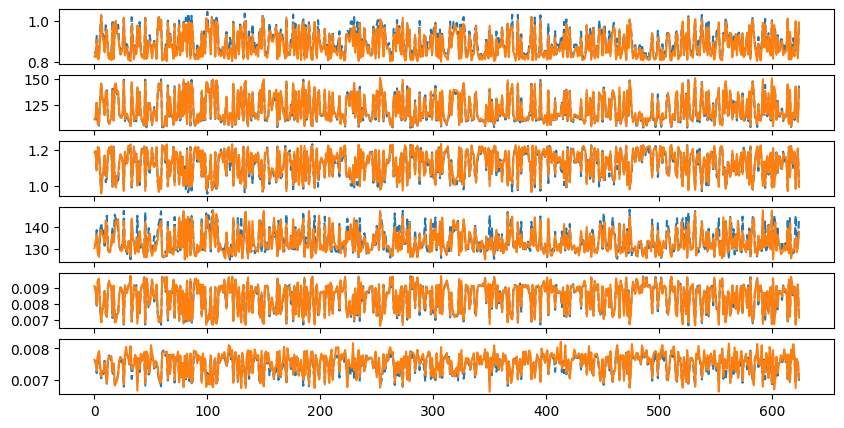

In [ ]:
_, feature_num = predictions_rvt.shape
fig, axs = plt.subplots(feature_num, figsize=(10, 5))

for f_index in range(feature_num):
    axs[f_index].plot(answers_org[:, f_index], linestyle="--")
    axs[f_index].plot(predictions_rvt[:, f_index])
# fig.show()

Text(0.5, 0, 'random index num')

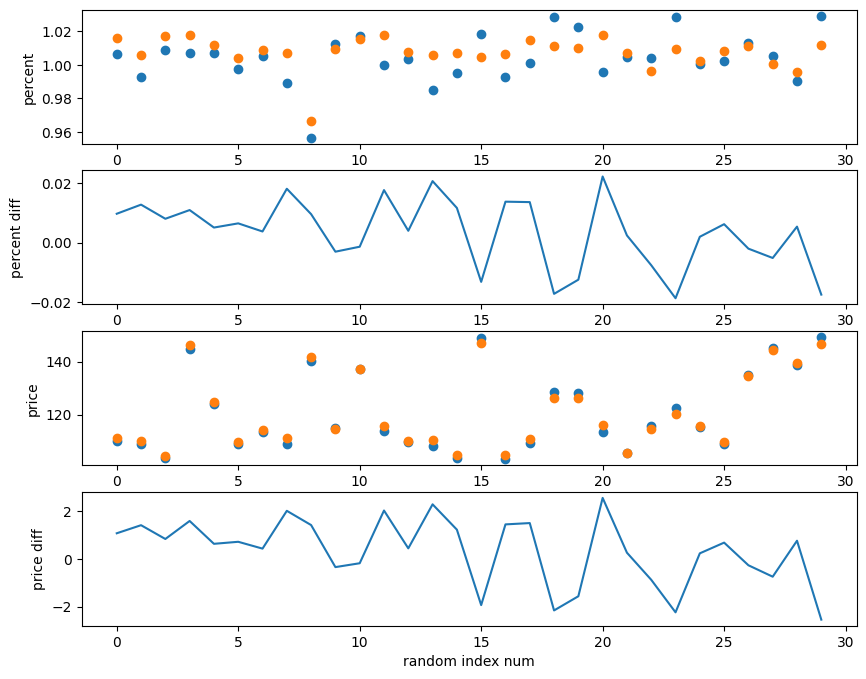

In [91]:
index = 30
f_index = 1
fig, axs = plt.subplots(4, figsize=(10, 8))

# since index is random, it looks like weird
axs[0].plot(answers_pct[index:index+30, f_index], linestyle="none", marker="o")
axs[0].plot(predictions_pct[index:index+30, f_index],linestyle="none", marker="o")
axs[0].set_ylabel("percent")
axs[1].plot(np.array(predictions_pct[index:index+30, f_index]) - np.array(answers_pct[index:index+30, f_index]))
axs[1].set_ylabel("percent diff")

axs[2].plot(answers_org[index:index+30, f_index], linestyle="none", marker="o")
axs[2].plot(predictions_rvt[index:index+30, f_index], linestyle="none", marker="o")
axs[2].set_ylabel("price")
price_diff = predictions_rvt[index:index+30, f_index] - answers_org[index:index+30, f_index]
axs[3].plot(price_diff)
axs[3].set_ylabel("price diff")
axs[3].set_xlabel("random index num")

In [93]:
np.mean(predictions_rvt - answers_org, axis=0)

array([-1.51658246e-02,  7.55345905e-01,  5.64881744e-03, -5.51035031e-01,
        2.27561870e-05,  5.36542257e-05])

Predict more steps

In [1081]:
answers_array = None
predictions_array = None
prediction_length = 5

for X, Y in ds:
    outputs = model(X)
    next_x = X
    predictions = None
    for i in range(prediction_length):
        output = outputs.permute(1, 0, 2)[:, -1:]
        next_x = torch.cat([next_x[:, 1:], output], dim=1)
        outputs = model(next_x)
        if predictions is None:
            predictions = output
        else:
            predictions = torch.cat([predictions, output], dim=1)
    
    index = ds._get_itr_ndx(ds._index) - 1 # batch size was added after interation
    y_ndx = ds.output_indices(index)
    y_ndx = ds.get_actual_index(y_ndx)
    answers = feature_df.iloc[y_ndx:y_ndx+prediction_length].values
    if len(answers) < prediction_length:
        break

    predictions = predictions.cpu().detach().numpy()
    if predictions_array is None:
        predictions_array = predictions[np.newaxis, :]
        answers_array = answers[np.newaxis, :]
    else:
        predictions_array = np.append(predictions_array, predictions[np.newaxis, :], axis=0)
        answers_array = np.append(answers_array, answers[np.newaxis, :], axis=0)

In [ ]:
import matplotlib.pyplot as plt

_, num_symbols, p_length, num_features = predictions_array.shape

fig, axs = plt.subplots(num_symbols*num_features, p_length , figsize=(4*p_length, 4*num_features*num_symbols))

for symbol_index in range(num_symbols):
    symbol_str = symbols[symbol_index]
    f_columns = feature_df[symbol_str].columns

    for f_index in range(num_features):
        # axs[s_index, 0].set_title(f"{symbol_str}:{f_columns[f_index]}")
        for l_index in range(p_length):
            s_index = symbol_index*num_features + f_index
            axs[s_index, l_index].scatter(answers_array[:, l_index, s_index], predictions_array[:, symbol_index, l_index, f_index], alpha=0.3)
fig.show()

### Evaluation Loop

In [25]:
import pandas as pd

symbol_df = pd.read_csv("L:/data/stocknet/logs/gnn/symbol_features_p10_token.csv", header=[0, 1], index_col=0)
# com_df = pd.read_csv("commodity_features_token.csv", header=[0, 1], index_col=0)
# bond_df = pd.read_csv("bond_diff_token.csv", header=0, index_col=0)
# bond_sdiff_df = pd.read_csv("bond_symbol_diff_token.csv", header=0, index_col=0)
# stock_df = pd.read_csv("stock_pct_token.csv", header=0, index_col=0)

tokens = {
    "currency": symbol_df,
    # "commodity": com_df,
    # "bond": bond_df,
    # "stock": stock_df
}

feature_df = load_token_df(tokens)
feature_df.head()

symbol                 USD                             EUR                  \
attribute  USDJPY_ratio_10 USDEUR_ratio_10 EURUSD_ratio_10 EURJPY_ratio_10   
2002-03-19        0.506653        0.528679        0.615668        0.726987   
2002-03-20        0.501624        0.531479        0.612122        0.720353   
2002-03-24        0.587144        0.588098        0.541221        0.724312   
2002-03-25        0.722038        0.627073        0.493303        0.777899   
2002-03-26        0.751111        0.616880        0.505766        0.804077   

symbol                 JPY                  
attribute  JPYUSD_ratio_10 JPYEUR_ratio_10  
2002-03-19        0.596814        0.345243  
2002-03-20        0.601375        0.352734  
2002-03-24        0.524709        0.348261  
2002-03-25        0.407462        0.288475  
2002-03-26        0.382764        0.259772

In [ ]:
import pandas as pd

ds = FeatureDataset(feature_df, symbols=["USD", "EUR", "JPY"], observation_length=10, device="cpu")

In [27]:
symbols = ["USD", "EUR", "JPY"]

column_symbols = []
for symbol in symbols:
    for c_symbol in symbols:
        if symbol != c_symbol:
            column_symbols.append(f"{symbol}{c_symbol}")

In [ ]:
periods = ["10", "20"]
model_versions = [1, 2, 3, 4]
model_names = [f"gnn_d{period}" for period in periods]

symbols = ["USD", "EUR", "JPY"]

inner_losses = None
answers = None
predictions = None

for model_name in model_names:
    params, model, optimizer, scheduler = load_model(
        model_name=model_name,
        model_version=model_version,
        device="cpu",
        train=False,
        model_folder="L:/data/stocknet/logs/gnn",
        model_class=TimeGraphModel,
        optimizer_class=torch.optim.Adam,
        scheduler_class=torch.optim.lr_scheduler.StepLR
    )

    ds.eval()
    model = model.eval()

    for X, Y in ds:
        outputs = model(X)  # Shape: (length, num_nodes, out_features)
        loss = criterion(outputs[-1], Y)

        ans = Y.cpu().detach().numpy()
        pre = outputs[-1].cpu().detach().numpy()
        ans = ans.reshape(1, *ans.shape)
        pre = pre.reshape(1, *pre.shape)

        if answers is None:
            answers = ans
            predictions = pre
        else:
            answers = np.append(answers, ans, axis=0)
            predictions = np.append(predictions, pre, axis=0)

    symbol_losses = None
    for i, symbol in enumerate(symbols):
        symbol_loss = np.mean((answers[:, i] - predictions[:, i]) ** 2, axis=0)
        if symbol_losses is None:
            symbol_losses = np.mean((answers[:, i] - predictions[:, i]) ** 2, axis=0)
        else:
            symbol_losses = np.append(symbol_losses, np.mean((answers[:, i] - predictions[:, i]) ** 2, axis=0))


In [ ]:
token_param_file = "symbol_feature_token_params.csv"
token_params = pd.read_csv(token_param_file, header=[0, 1], index_col=0)
symbol = "USDJPY"
symbol_index = [0,0] # node_num, feature_num
method = "ratio_10"

token_param = token_params[method]
token_df = feature_df.xs(f"{symbol}_{method}", axis=1, level=1)
apx_min = token_param.loc[symbol, "min"]
apx_max = token_param.loc[symbol, "max"]

answers = None
answers_pct = None
answers_org = None

predictions = None
predictions_pct = None
predictions_rvt = None

for X, Y in ds:
    index = ds._get_itr_ndx(ds._index) - 1 # batch size was added after interation
    y_ndx = ds.output_indices(index)
    y_ndx = ds.get_actual_index(y_ndx)

    outputs = model(X)

    ans = Y.cpu().detach().numpy()
    pre = outputs[-1].cpu().detach().numpy()
    ans = ans.reshape(1, *ans.shape)
    pre = pre.reshape(1, *pre.shape)

    # test: check if the index is correct
    # source_ans = token_df.iloc[y_ndx]
    # print(ans[0, *symbol_index], source_ans[0])

    # assume token_df and original df has the same indices (i.e. no dropna)
    # test: check one output with answer
    # output = ans[0, *symbol_index]
    output = pre[0, *symbol_index]
    denominator_index = token_df.iloc[y_ndx-period].name
    pct_value = (output * (apx_max - apx_min) + apx_min)
    reverted_value = pct_value * df.loc[denominator_index, symbol]
    answer_index = token_df.iloc[y_ndx].name
    answer_value = df.loc[answer_index, symbol]

    # print(reverted_value, answer_value)

    if answers is None:
        answers = ans
        answers_pct = token_df.iloc[y_ndx].values * (apx_max - apx_min) + apx_min
        answers_org = [answer_value]

        predictions = pre
        predictions_pct = [pct_value]
        predictions_rvt = [reverted_value]
    else:
        answers = np.append(answers, ans, axis=0)
        answers_pct = np.append(answers_pct, token_df.iloc[y_ndx].values * (apx_max - apx_min) + apx_min, axis=0)
        answers_org.append(answer_value)

        predictions = np.append(predictions, pre, axis=0)
        predictions_pct.append(pct_value)
        predictions_rvt.append(reverted_value)